# モデル予測制御をMMGモデルに適用するプログラム

do_mpcを利用してMMGモデルでMPCを実施する


## MMGモデルの関数

先にMMGモデルの各種力を計算する関数を出しておく

### 船体に働く流体力について
$$
X_H=\frac{1}{2}\rho L_{pp}dU^2X'_H(\beta,r')  \\
Y_H=\frac{1}{2}\rho L_{pp}dU^2Y'_H(\beta,r')  \\
N_H=\frac{1}{2}\rho L_{pp}^2dU^2N'_H(\beta,r')  \\
\beta=tan^{-1}\left(\frac{-v}{u}\right)  \\
r'=\frac{rL_{pp}}{U}
$$

In [8]:
#運動方程式を有次元値で扱っている
def X_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    return 0.5*ρ*L_pp*d*U**2*X_H_dash(v,r_dash)

def Y_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    return 0.5*ρ*L_pp*d*U**2*Y_H_dash(v,r_dash)

def N_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    return 0.5*ρ*L_pp**2*d*U**2*N_H_dash(v,r_dash)

### 船体に働く流体力(無次元)

操縦流体力微係数を用いて無次元の流体力を表す
$$
X'_H=R'_0+X'_{\beta\beta}\beta^2+X'_{\beta r}\beta r+X'_{rr}r'^2+X'_{\beta\beta\beta\beta}\beta^4  \\
Y'_H=Y'_{\beta}\beta+Y'_{r}r'+Y'_{\beta\beta r}\beta^2r'+Y'_{\beta rr}\beta r'^2+Y'_{\beta\beta\beta}\beta^3+Y'_{rrr}r'^3  \\
N'_H=N'_{\beta}\beta+N'_{r}r'+N'_{\beta\beta r}\beta^2r'+N'_{\beta rr}\beta r'^2+N'_{\beta\beta\beta}\beta^3+N'_{rrr}r'^3
$$

In [9]:
#斜航角ではなく横方向の速度の無次元化成分を使う？
def X_H_dash(β,r_dash):
    return R_0_dash+X_vv_dash*β**2+X_vr_dash*β*r_dash+X_rr_dash*r_dash**2+X_vvvv_dash*β**4

def Y_H_dash(β,r_dash):
    return Y_v_dash*β+Y_r_dash*r_dash+Y_vvr_dash*β**2*r_dash+Y_vrr_dash*β*r_dash**2+Y_vvv_dash*β**3+Y_rrr_dash*r_dash**3

def N_H_dash(β,r_dash):
    return N_v_dash*β+N_r_dash*r_dash+N_vvr_dash*β**2*r_dash+N_vrr_dash*β*r_dash**2+N_vvv_dash*β**3+N_rrr_dash*r_dash**3

### 舵に働く力

舵に働く力を表す数式

$$
X_R=-(1-t_R)F_N(u,v,\delta,n_p)\sin(\delta)  \\
Y_R=-(1+a_H)F_N(u,v,\delta,n_p)\cos(\delta)  \\
N_R=-(x_R+a_Hx_H)F_N(u,v,\delta,n_p)\cos(\delta)  \\
F_N=\frac{1}{2}\rho A_Ru_R^2f_{\alpha}\alpha_R  \\
u_p=(1-w_{P0}u  \\
u_\infty=u_p \sqrt{1+\frac{8K_T}{\pi J^2}}  \\
\kappa=\frac{k_x}{\varepsilon_w}  \\
u_{RP}=u_p+k_x\Delta u  \\
u_R=\sqrt{\eta u_RP^2+(1-\eta)u_p^2}  \\
U=\sqrt{u^2+v^2}
v_R=U\gamma_{R+}(\beta-l_{r'}r')  \\
\alpha_R=\delta-tan^{-1}\left(\frac{v_R}{u_R}\right)
$$

In [10]:
def X_R(u,n_p):
    return -(1-t_R)*F_N(u,v,δ,n_p)*np.sin(δ)

def Y_R(u,v,δ,n_p):
    return -(1+a_H)*F_N(u,v,δ,n_p)*np.cos(δ)

def N_R(u,v,δ,n_p):
    return -(x_R+a_H*x_H)*F_N(u,v,δ,n_p)*np.cos(δ)

def F_N(u,v,δ,n_p):
    u_p=(1-w_P0)*u
    u_inf=u_p*np.sqrt(1+(8*K_T(u,n_p))/(np.pi*J(u,n_p)**2))
    k_x=κ*ϵ
    delta_u=u_inf-u_p
    u_RP=u_p+k_x*delta_u
    u_R=np.sqrt(η*u_RP**2+(1-η)*u_p**2)
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    v_R=U*γ_R_plus*(β-l_r_dash*r_dash)
    α_R=δ-np.arctan(v_R/u_R)
    return 0.5*ρ*A_R*u_R**2*f_α*α_R

### プロペラに働く力

プロペラに働く力についての数式

$$
X_P=(1-t_P)T_P(u,n_p)  \\
K_T=k_0+k_1J(u,n_p)+k_2J(u,n_p)^2  \\
J(u,n_p)=u\frac{1-w_{P0}}{n_pD_p}  \\
T_P(u,n_p)=K_T\rho n_p^2D_p^4
$$

In [11]:
def X_P(u,v,δ,n_p):
    return (1-t_P)*T_P(u,n_p)

def K_T(u,n_p):
    return k_0+k_1*J(u,n_p)+k_2*J(u,n_p)**2

def J(u,n_p):
    return u*(1-w_P0)/(n_p*D_p)

def T_P(u,n_p):
    return K_T(u,n_p)*ρ*n_p**2*D_p**4

## MPCプログラム
ここからモデル予測制御についてのプログラム

In [12]:
import numpy as np
import do_mpc
from casadi import vertcat

import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

## モデルの作成

モデルのタイプとして'discrete'(離散的)か'continuous'(連続的)かを選択する

In [13]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

## 変数の設定

### 入出力の変数設定

- 状態量 : var_type='_x'
- 操作量 : var_type='_u'

操作量は舵角$\delta$とプロペラ回転数$n_p$  
状態量は$x,y,u,v,r,\psi$


$\delta$ : 舵角  
$n_p$ : プロペラ回転数  
$u$ : 船首方向の船速  
$v$ : 横方向の船速  
$r$ : 旋回角速度  
$x,y$ : 船の座標  
$\psi$ : 船首角(船首とx軸正の向きの角度)

In [14]:
δ = model.set_variable(var_type='_u', var_name='δ', shape=(1,1)) #舵角
n_p=model.set_variable(var_type='_u',var_name='n_p',shape=(1,1)) #プロペラ回転数

u = model.set_variable(var_type='_x', var_name='u', shape=(1,1)) #前後方向速度
v = model.set_variable(var_type='_x', var_name='v', shape=(1,1)) #横方向速度
r = model.set_variable(var_type='_x', var_name='r', shape=(1,1)) #回頭角速度
x = model.set_variable(var_type='_x', var_name='x', shape=(1,1)) #船のx座標
y = model.set_variable(var_type='_x', var_name='y', shape=(1,1)) #船のy座標
ψ = model.set_variable(var_type='_x', var_name='ψ', shape=(1,1)) #船首角(x軸正の方向となす角)
δ_m=model.set_variable(var_type='_x',var_name='δ_m',shape=(1,1))
n_p_m=model.set_variable(var_type='_x',var_name='n_p_m',shape=(1,1))
x_ref=model.set_variable(var_type='_tvp',var_name='x_ref',shape=(1,1))
y_ref=model.set_variable(var_type='_tvp',var_name='y_ref',shape=(1,1))
psi_ref=model.set_variable(var_type='_tvp',var_name='psi_ref',shape=(1,1))

### パラメータの設定

時間によって変化しないパラメータを設定する
- 不確定性を与えない場合は'model.set_variable()'としなくてもいいらしい

In [15]:
#Certain parameters
ρ=1.025 #海水密度

L_pp = 7.00  # 船長Lpp[m]
B = 1.27  # 船幅[m]
d = 0.46  # 喫水[m]
nabla = 3.27  # 排水量[m^3]
x_G = 0.25  # 重心位置[m]
C_b = 0.810  # 方形係数[-]
D_p = 0.216  # プロペラ直径[m]
H_R = 0.345  # 舵高さ[m]
A_R = 0.0539  # 舵断面積[m^2]

t_P = 0.220  # 推力減少率
w_P0 = 0.40  # 有効伴流率
m_x_dash = 0.022  # 付加質量x(無次元)
m_y_dash = 0.223  # 付加質量y(無次元)
J_z_dash = 0.011  # 付加質量Izz(無次元)
t_R = 0.387  # 操縦抵抗減少率
a_H = 0.312  # 舵力増加係数
x_H_dash = -0.464  # 舵力増分作用位置
γ_R_minus = 0.395  # 整流係数
γ_R_plus = 0.640  # 整流係数
l_r_dash = -0.710  # 船長に対する舵位置
x_P_dash = -0.690  # 船長に対するプロペラ位置
ϵ = 1.09  # プロペラ・舵位置伴流係数比
κ = 0.50 # 修正係数
f_α = 2.747  # 直圧力勾配係数
x_R=-0.5 #舵直圧力作用点
    
m=ρ * nabla  # 質量(無次元化)[kg]
I_zG=ρ * nabla * ((0.25 * L_pp) ** 2)  # 慣性モーメント[-]
η=D_p / H_R # プロペラ直径に対する舵高さ(Dp/H)
m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash  # 付加質量x(無次元)
m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash  # 付加質量y(無次元)
J_z=(0.5 * ρ * (L_pp ** 4) * d) * J_z_dash  # 付加質量Izz(無次元)
x_H=x_H_dash * L_pp  # 舵力増分作用位置
    
    
k_0 = 0.2931
k_1 = -0.2753
k_2 = -0.1385
R_0_dash = 0.022
X_vv_dash = -0.040
X_vr_dash = 0.002
X_rr_dash = 0.011
X_vvvv_dash = 0.771
Y_v_dash = -0.315
Y_r_dash = 0.083
Y_vvv_dash = -1.607
Y_vvr_dash = 0.379
Y_vrr_dash = -0.391
Y_rrr_dash = 0.008
N_v_dash = -0.137
N_r_dash = -0.049
N_vvv_dash = -0.030
N_vvr_dash = -0.294
N_vrr_dash = 0.055
N_rrr_dash = -0.013

R0=0.5*ρ*(L_pp**2)*d*R_0_dash #船体抵抗

### 微分方程式の設定

$
\displaystyle
\dot{u}=\frac{X_H-R_0+X_R+X_P+(m+m_y)vr}{m+m_x}  \\
\displaystyle
\dot{v}=\frac{Y_H+Y_R-(m+m_x)ur}{m+m_y}  \\
\displaystyle
\dot{r}=\frac{N_H+N_R}{I_Z+J_Z}  \\
\displaystyle
\dot{x}=u\cos{\psi}-v\sin{\psi}  \\
\displaystyle
\dot{y}=u\sin{\psi}+v\cos{\psi}  \\
\displaystyle
\dot{\psi}=r  \\
$

In [16]:
Trd=11.9
model.set_rhs('u', (X_H(u,v,r)-R0+X_R(u,n_p_m)+X_P(u,v,δ,n_p_m)+(m+m_y)*v*r)/(m+m_x))
model.set_rhs('v', (Y_H(u,v,r)+Y_R(u,v,δ_m,n_p_m)-(m+m_x)*u*r)/(m+m_y))
model.set_rhs('r', (N_H(u,v,r)+N_R(u,v,δ_m,n_p_m))/(I_zG+J_z))
model.set_rhs('x', u * np.cos(ψ) - v * np.sin(ψ))
model.set_rhs('y', u * np.sin(ψ) + v * np.cos(ψ))
model.set_rhs('ψ', r)
model.set_rhs('δ_m',(δ-δ_m))
model.set_rhs('n_p_m',n_p-n_p_m)

In [17]:
model.setup()

## MPCコントローラの形成

n_horizon、t_step、n_robustを設定する。  

In [18]:
mpc = do_mpc.controller.MPC(model)

n_horizon = 100
t_step = 1.0
n_robust = 1 # default to 0
store_full_solution = True

setup_mpc = {
    'n_horizon': n_horizon,
    't_step': t_step,
    'n_robust': n_robust,
    'store_full_solution': store_full_solution,
}

mpc.set_param(**setup_mpc)

## 目標軌道の設定
MPCの目標軌道として円軌道を作成する

In [19]:
radius=50
speed=3

η=[]
η_x=[]
η_y=[]
η_psi=[]

for t in range(400):
    η_x.append(radius*np.sin(speed*t/radius))
    η_y.append(radius-radius*np.cos(speed*t/radius))
    η_psi.append(np.arctan2(speed*np.sin(speed*t/radius),speed*np.cos(speed*t/radius)))

η=np.array([η_x,η_y,η_psi])

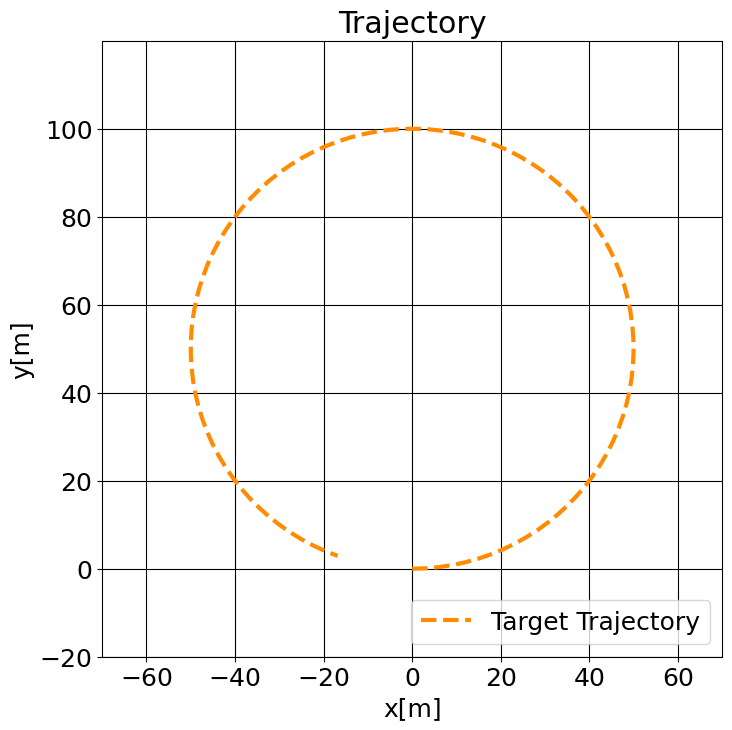

In [20]:
fig=plt.figure(figsize=(8.0,8.0))
plt.plot(η_x[:100],η_y[:100],label="Target Trajectory",c="darkorange",linestyle='dashed')
plt.title("Trajectory")
plt.xlim([-70, 70])
plt.ylim([-20, 120])
plt.legend(loc='lower right')
plt.grid(which='major',color='black',linestyle='-')
plt.grid(which='minor',color='black',linestyle='-')
plt.xticks(list(filter(lambda x: x%20==0, np.arange(-70,70))))
plt.yticks(list(filter(lambda x: x%20==0, np.arange(-20,120))))
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.show()
fig.savefig("mpc_traget.png")

### 評価関数の設定

$
C=\sum_{k=0}^{n-1}(\underbrace{l\left(x_{k}, u_{k}, z_{k}, p\right)}_{\text {lagrange term }}+\underbrace{\Delta u_{k}^{T} R \Delta u_{k}}_{\text {r-term }})+\underbrace{m\left(x_{n}\right)}_{\text {meyer term }}
$

今回は、目標軌道を追従するような目的関数を設定する

時刻kごとに目標座標$x_k^{ref},y_k^{ref}$を変化させることで軌道追従ができる 

$lagrange term=\sum_{k=0}^{n-1}((x_k-x_k^{ref})^2+(y_k-y_k^{ref})^2)$  
$r-term=\Delta u_k^TR\Delta u_k$  
$meyer=(x_n-x_n^{ref})^2+(y_n-y_n^{ref})^2$

In [21]:
lterm=(model.x['x']-model.tvp['x_ref'])**2+(model.x['y']-model.tvp['y_ref'])**2
mterm=lterm
mpc.set_objective(mterm=mterm,lterm=lterm)

$\Delta u_k^TR\Delta u_k$の設定

In [22]:
mpc.set_rterm(δ = 1e-3)

In [23]:
tvp_template = mpc.get_tvp_template()

## 時間ごとに目標とする座標を変更する関数
MPCでの関数名とsimulatorでの関数名を異なるものにする必要がある(同じだとエラーが発生する)  
現状、プログラムを回すたびに$x_{ref}$,$y_{ref}$を変更しなければならない

In [24]:
def tvp_fun(t_now):
    for k in range(n_horizon):
        tvp_template['_tvp',k,'x_ref']=np.array([η_x[int(t_now+k)]])
        tvp_template['_tvp',k,'y_ref']=np.array([η_y[int(t_now+k)]])
        tvp_template['_tvp',k,'psi_ref']=np.array([η_psi[int(t_now+k)]])
    return tvp_template

In [25]:
mpc.set_tvp_fun(tvp_fun)

### 変数の制約(最大値・最小値)の設定

操作量の初期値はこの制約の最大値に一致しているみたい  
- 自分で変更する方法を知りたい

In [26]:
mpc.bounds['lower','_u', 'δ'] = - 45 * np.pi / 180
mpc.bounds['upper','_u', 'δ'] = 45 * np.pi / 180
mpc.bounds['lower','_x','u']=0.0
mpc.bounds['upper','_x','u']=15.0
mpc.bounds['lower','_x','v']=-5.0
mpc.bounds['upper','_x','v']=5.0
mpc.bounds['lower','_u','n_p']=0.0
mpc.bounds['upper','_u','n_p']=20.0

In [27]:
mpc.setup()

## シミュレータの設定

In [28]:
simulator = do_mpc.simulator.Simulator(model)

t_stepを設定する必要がある

In [29]:
simulator.set_param(t_step = 1)

In [30]:
tvp_sim_template=simulator.get_tvp_template()

### 時間変化する軌道上の目標座標の設定

シミュレータでも時刻ごとの目標座標を設定する必要がある

In [31]:
def tvp_sim_fun(t_now):
    for k in range(n_horizon):
        tvp_template['_tvp',k,'x_ref']=np.array([η_x[int(t_now+k)]])
        tvp_template['_tvp',k,'y_ref']=np.array([η_y[int(t_now+k)]])
        tvp_template['_tvp',k,'psi_ref']=np.array([η_psi[int(t_now+k)]])
    return tvp_sim_template

In [32]:
simulator.set_tvp_fun(tvp_sim_fun)

In [33]:
simulator.setup()

## コントロールループの設定

### 初期値の設定

状態量の初期値を設定する.  
最初に設定した状態量の変数すべてに初期値を設定する必要がある  
その初期値をsimulatorとmpcの両方に設定する

In [34]:
# x0 = np.array([0.0, 20.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(-1,1)
x0 = np.array([3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()

In [35]:
mpc.x0.keys()

['u', 'v', 'r', 'x', 'y', 'ψ', 'δ_m', 'n_p_m']

### グラフの設定

In [36]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [37]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(3, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [38]:
%%capture
for g in [sim_graphics, mpc_graphics]:
#     g.add_line(var_type='_x', var_name='x', axis=ax[0])
    g.add_line(var_type='_x', var_name='y', axis=ax[0])
    g.add_line(var_type='_x', var_name='ψ', axis=ax[1])
    g.add_line(var_type='_u', var_name='δ', axis=ax[2])
    
ax[0].set_ylabel('[m]')
ax[1].set_ylabel('azimuth [rad]')
ax[2].set_ylabel('delta [rad]')
ax[2].set_xlabel('time [s]')

### MPCの最適化を実施

In [39]:
u0 = mpc.make_step(x0)

C:\Users\yamamoto\AppData\Local\Temp\ipykernel_26904\1527870087.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tvp_template['_tvp',k,'x_ref']=np.array([η_x[int(t_now+k)]])
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_26904\1527870087.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tvp_template['_tvp',k,'y_ref']=np.array([η_y[int(t_now+k)]])
C:\Users\yamamoto\AppData\Local\Temp\ipykernel_26904\1527870087.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    12208
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4801

Total number of variables............................:     3432
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      992
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3208
Total number of inequality c

In [40]:
# u0 = mpc.make_step(x0)

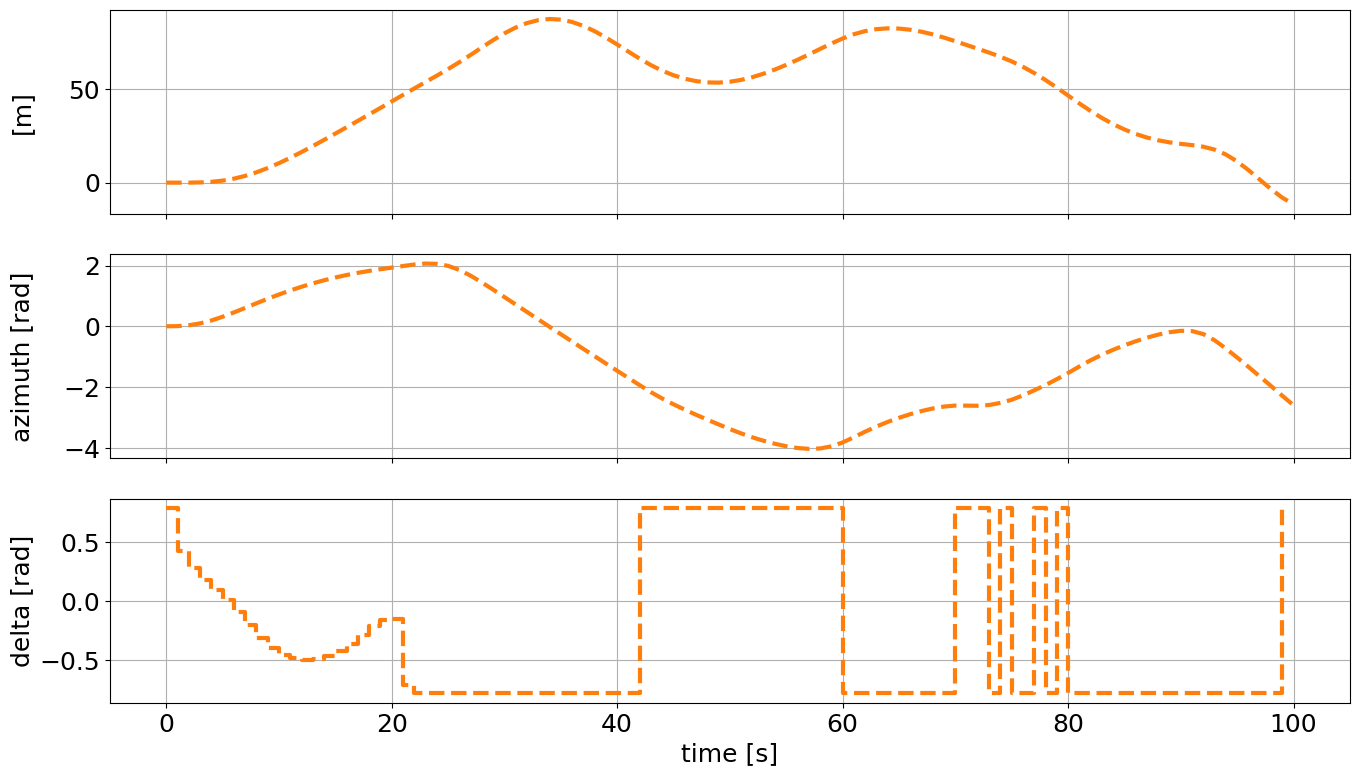

In [41]:
sim_graphics.clear()
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [42]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [43]:
%%capture
for i in range(n_horizon):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

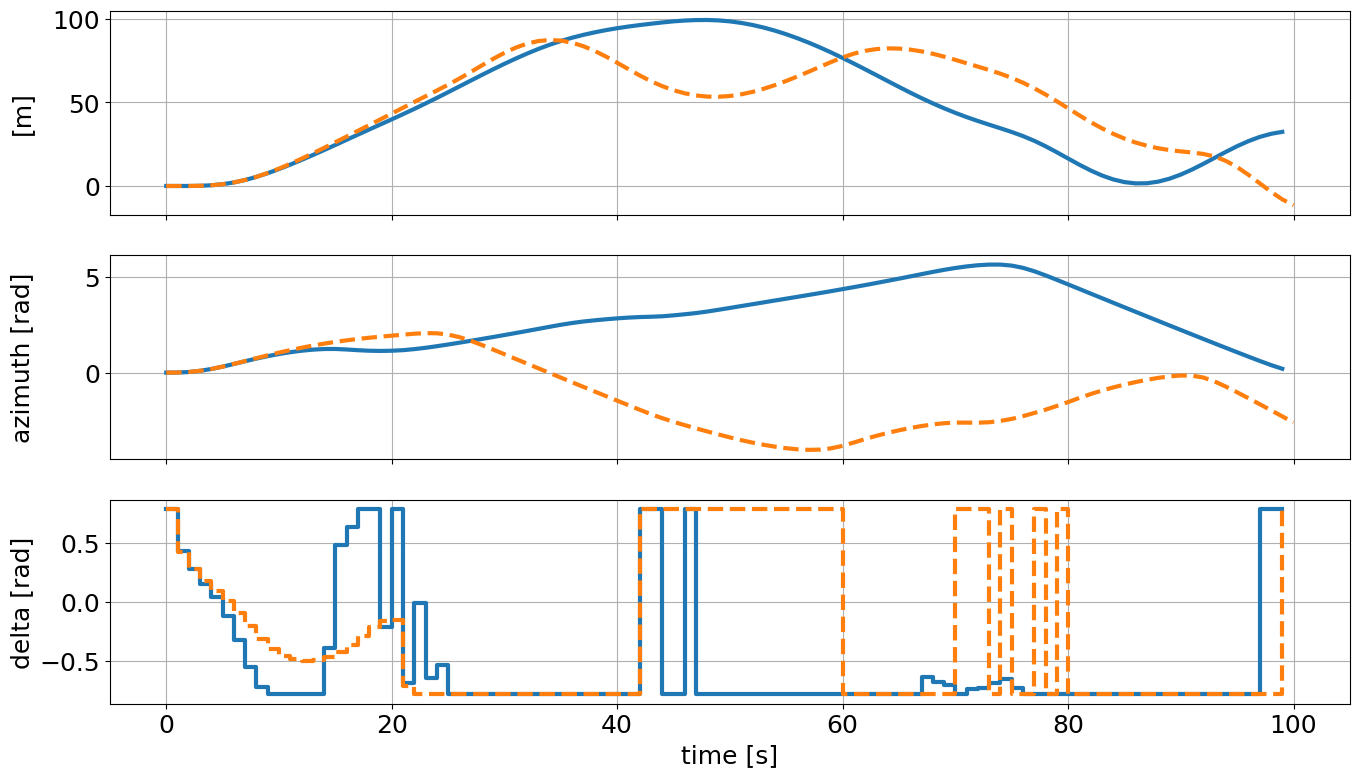

In [44]:
sim_graphics.clear()
mpc_graphics.clear()
# Plot predictions from t=0
# mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

青線はシミュレータで得られた船の軌道・船首角・舵角の時間変化  
黄色の線はt=0の時の予測の船の軌道・船首角・舵角の時間変化

In [45]:
# remove past results
!rm -rf results/

# save present result
from do_mpc.data import save_results, load_results
save_results([mpc, simulator])
results = load_results('./results/results.pkl')

'rm' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B


In [46]:
results['simulator']['_x'].shape

(100, 6)

## ship3DoFを使って可視化

In [47]:
from shipmmg.ship_obj_3dof import ShipObj3dof
ship_kt = ShipObj3dof(L=7.00, B=1.27)
ship_kt.time  = np.linspace(0.00, n_horizon*t_step, n_horizon)
ship_kt.u = results['simulator']['_x','u'].reshape(-1)
ship_kt.v = results['simulator']['_x','v'].reshape(-1)
ship_kt.r = results['simulator']['_x','r'].reshape(-1)
ship_kt.x = results['simulator']['_x','x'].reshape(-1)
ship_kt.y = results['simulator']['_x','y'].reshape(-1)
ship_kt.psi = results['simulator']['_x','ψ'].reshape(-1)
ship_kt.δ = results['simulator']['_x','δ_m'].reshape(-1)
ship_kt.x_ref=results['mpc']['_tvp','x_ref'].reshape(-1)
ship_kt.y_ref=results['mpc']['_tvp','y_ref'].reshape(-1)
ship_kt.psi_ref=results['mpc']['_tvp','psi_ref'].reshape(-1)
ship_kt.np=results['simulator']['_x','n_p_m'].reshape(-1)

Exception: Error occured in struct context with powerIndex ('δ_m',), at canonicalIndex ()

In [ ]:
plt.plot(ship_kt.time, list(map(lambda ψ: ψ * 180 / np.pi ,ship_kt.psi)), label='$\psi$')
plt.plot(ship_kt.time, list(map(lambda δ: δ * 180 / np.pi ,ship_kt.δ)), label='$\delta$')
plt.xlabel('time [s]')
plt.ylabel('[degree]')
plt.legend();

: 

In [ ]:
ship_kt.draw_xy_trajectory(aspect_equal=False)

: 

シミュレータで得られた船のxy平面上での軌道

In [ ]:
ship_kt.draw_gif(frate=1, save_fig_path='MMG_MPC_demo00.gif')

: 

### 実際に制御された軌道・方位角・舵角の表示

シミュレーションによって得られた軌道・方位角・舵角のみを表示するように抽出  
軌道には目標軌道も載せる

In [ ]:
blue='#1f77b4'
yellow='#ff7f0e'
t=np.linspace(0,100,n_horizon)
fig,(fig_y_t,fig_azimus_t,fig_delta_t)=plt.subplots(3,1,figsize=(16,9),sharex=True)

fig_y_t.plot(t,ship_kt.y,color=blue,label='trajectory')
fig_y_t.plot(t,ship_kt.y_ref,color=yellow,label='target',linestyle='dashed')

fig_azimus_t.plot(t,ship_kt.psi,color=blue)

#δを滑らかではなく表示
ship_delta_x=[]
ship_delta_y=[]
for k in range(2*n_horizon):
    x=(k+1)//2
    y=k//2
    ship_delta_x.append(x)
    ship_delta_y.append(ship_kt.δ[y])
fig_delta_t.plot(ship_delta_x,ship_delta_y,color=blue)

fig_delta_t.set_xlabel('time[s]')
fig_y_t.set_ylabel('y[m]')
fig_azimus_t.set_ylabel('azimuth[rad]')
fig_delta_t.set_ylabel('delta[rad]')
fig.align_ylabels()
fig_y_t.legend(loc='lower right')
fig.show()
fig.savefig("mmg_time_varing_result.png")

: 

In [ ]:
x_ref=list(ship_kt.x_ref)
y_ref=list(ship_kt.y_ref)
x=list(ship_kt.x)
y=list(ship_kt.y)
ψ=list(ship_kt.psi) 
psi_ref=list(ship_kt.psi_ref)

: 

### 時刻による誤差の表示

時刻$t$における誤差は$\sqrt{(x_t-x^{ref}_t)^2+(y_t-y^{ref}_t)^2}$で与えられるとして誤差を計算し、表示した。

In [ ]:
max_d=0
index=0
e=[]
for i in range(100):
    e.append(np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2))
    if max_d<np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2):
        max_d=np.sqrt((x[i]-x_ref[i])**2+(y[i]-y_ref[i])**2)
        index=i
print(max_d,index)
fig,ax=plt.subplots(figsize=(16,3))
ax.plot(t,e)
ax.set_xlabel('time[s]')
ax.set_ylabel('error[m]')
plt.show()
fig.savefig('img_error.png')

: 

## 目標軌道とsimulationとの比較
この回の軌道と実際にsimulationで得られた軌道の比較をする

In [ ]:
fig=plt.figure(figsize=(8.0,8.0))
plt.plot(x,y,label="Trajectory")
plt.plot(x_ref,y_ref,c="darkorange",label="Target Trajectroy",linestyle="dashed")
plt.title("")
plt.xlim([-70,70])
plt.ylim([-20,120])
plt.legend(loc='lower right')
plt.xticks(list(filter(lambda x: x%20==0,np.arange(-70,70))))
plt.yticks(list(filter(lambda x: x%20==0, np.arange(-20,120))))
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.show()
fig.savefig("img_mmg_result_01.png")

: 

In [ ]:
blue='#1f77b4'
yellow='#ff7f0e'
t=np.linspace(0,100,n_horizon)
fig,(fig_x_t,fig_y_t,fig_u_t,fig_v_t,fig_psi_t,fig_np)=plt.subplots(6,1,figsize=(16,18),sharex=True)

fig_x_t.plot(t,ship_kt.x,color=blue,label='trajectory')
fig_x_t.plot(t,ship_kt.x_ref,color=yellow,label='target',linestyle='dashed')

fig_y_t.plot(t,ship_kt.y,color=blue,label='trajectory')
fig_y_t.plot(t,ship_kt.y_ref,color=yellow,label='target',linestyle='dashed')

fig_u_t.plot(t,ship_kt.u,color=blue,label='trajectory')
fig_v_t.plot(t,ship_kt.v,color=blue,label='trajectory')

fig_psi_t.plot(t,ship_kt.psi,color=blue,label='trajectory')

fig_np.plot(t,ship_kt.np,color=blue,label='trajectory')

fig_np.set_xlabel('time[s]')
fig_x_t.set_ylabel('x[m]')
fig_y_t.set_ylabel('y[m]')
fig_u_t.set_ylabel('u[m/s]')
fig_v_t.set_ylabel('v[m/s]')
fig_psi_t.set_ylabel('azimuth[rad]')
fig_np.set_ylabel('np[rpm]')

fig.align_ylabels()
fig_x_t.legend(loc='lower right')
fig_y_t.legend(loc='lower right')
fig.show()
fig.savefig("time_varing_result_01.png")

: 

### 時刻によるx座標、y座標の変化

In [ ]:
t=np.linspace(0,100,n_horizon)
fig,(fig_x_t,fig_y_t)=plt.subplots(2,1,figsize=(16,6),sharex=True)

fig_x_t.plot(t,ship_kt.x,color=blue,label='trajectory')
fig_x_t.plot(t,ship_kt.x_ref,color=yellow,label='target',linestyle='dashed')

fig_y_t.plot(t,ship_kt.y,color=blue,label='trajectory')
fig_y_t.plot(t,ship_kt.y_ref,color=yellow,label='target',linestyle='dashed')

fig_y_t.set_xlabel('time[s]')
fig_x_t.set_ylabel('x[m]')
fig_y_t.set_ylabel('y[m]')

fig.align_ylabels()
fig_x_t.legend(loc='lower right')
fig_y_t.legend(loc='lower right')
fig.show()
fig.savefig("time_varing_result_02.png")

: 

### 時刻による前後方向速度、横方向速度、方位角、プロペラ回転数の変化

In [ ]:
t=np.linspace(0,100,n_horizon)
fig,(fig_u_t,fig_v_t,fig_psi_t,fig_np)=plt.subplots(4,1,figsize=(16,12),sharex=True)

fig_u_t.plot(t,ship_kt.u,color=blue,label='trajectory')
fig_v_t.plot(t,ship_kt.v,color=blue,label='trajectory')

fig_psi_t.plot(t,ship_kt.psi,color=blue,label='trajectory')

fig_np.plot(t,ship_kt.np,color=blue,label='trajectory')

fig_np.set_xlabel('time[s]')

fig_u_t.set_ylabel('u[m/s]')
fig_v_t.set_ylabel('v[m/s]')
fig_psi_t.set_ylabel('azimuth[rad]')
fig_np.set_ylabel('np[rpm]')

fig.align_ylabels()

fig.show()
fig.savefig("time_varing_result_03.png")

: 

: 